<a href="https://colab.research.google.com/github/ArturSViana/Churn_Telecom/blob/main/ChurnTelecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução

O objetivo deste projeto é entender o perfil dos clientes que encerraram contrato com uma empresa de Telecom, seus possíveis motivos, sugestões de melhoria para, posteriormente, criar um modelo que classifique o clientes prpoensos a dar churn dadas às características deles



### Perguntas:

- Quais são as principais variáveis de influência no churn?
- Qual a maior porcentagem etaria dos churns?
- Quanto tempo leva, em sua maioria, para ocorrer o churn?




# 2. Set-up

> ## 2.1 Importando as bibliotecas


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

> ## 2.2 Lendo o dataset

In [ ]:
df = pd.read_csv(r'/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# remover colunas que não são relevantes para o modelo
df.drop(['customerID'], axis=1, inplace=True)

# é necessário tratar os valores ' ' contidos na coluna 'TotalCharges' que não são nulos para alterar o tipo da coluna para float
nulos = df.loc[df['TotalCharges']==' ']
print(nulos['TotalCharges'].count())
df = df.drop(nulos.index, axis=0)
df['TotalCharges']=df['TotalCharges'].astype(float)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

11


>> ### Atributos do dataset:

  - customerID - ID do cliente

  - sexo - Se o cliente é homem ou mulher

  - SeniorCitizen - Se o cliente é um idoso (1, 0)

  - Parceiro - Se o cliente tem um parceiro (Sim, Não)

  - Dependentes - Se o cliente tem dependentes (Sim, Não)

  - tenure - Número de meses que o cliente permaneceu na empresa

  - PhoneService - Se o cliente possui um serviço telefônico (Sim, Não)

  - MultipleLines - Se o cliente tem várias linhas (Sim, Não, Sem serviço telefônico)

  - InternetService - Provedor de serviços de Internet do cliente (DSL, Fibra ótica, Não)

  - OnlineSecurity - Se o cliente tem segurança online (Sim, Não, Sem serviço de internet)

  - OnlineBackup - Se o cliente tem backup online ou não (Sim, Não, Sem serviço de internet)

  - DeviceProtection - Se o cliente tem proteção de dispositivo (Sim, Não, Sem serviço de internet)

  - TechSupport - Se o cliente tem suporte técnico (Sim, Não, Sem serviço de internet)

  - StreamingTV - Se o cliente possui serviço de streaming de TV (Sim, Não, Sem serviço de internet)

  - StreamingMovies - Se o cliente possui serviço de streaming de filmes (Sim, Não, Sem serviço de internet)

  - Contrato - Indica o tipo de contrato (Mês a mês, Um ano, Dois anos)

  - PaperlessBilling - Se o cliente tem faturamento sem papel (Sim, Não)

  - PaymentMethod - Indica a forma de pagamento (Cheque Eletrônico, Cheque Postado, Transferência Bancária (automática), Cartão de Crédito (automática))

  - MonthlyCharges - Indica o custo atual da assinatura mensal do cliente

  - TotalCharges - Indica o total de cobranças pagas pelo cliente até o momento

  - Churn - Indica se o cliente cancelou

# 3. Pré processamento dos dados (inicial)

In [ ]:
# criando dois novos df a partir do original, separando clientes ativos e que deram churn
churns = df[df['Churn']=='Yes']
clientes = df[df['Churn']=='No']


> ## 3.1. Tratando valores faltantes e transformando tipos de dados

In [ ]:


# converter dados categóricos em numéricos
encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = encoder.fit_transform(df[col])

# normalizar os dados numéricos
scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.280248,0,1,0,0,2,0,0,0,0,0,1,2,-1.161694,-0.994194,0
1,1,0,0,0,0.064303,1,0,0,2,0,2,0,0,0,1,0,3,-0.260878,-0.173740,0
2,1,0,0,0,-1.239504,1,0,0,2,2,0,0,0,0,0,1,3,-0.363923,-0.959649,1
3,1,0,0,0,0.512486,0,1,0,2,0,2,2,0,0,1,0,0,-0.747850,-0.195248,0
4,0,0,0,0,-1.239504,1,0,1,0,0,0,0,0,0,0,1,2,0.196178,-0.940457,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,-0.343137,1,2,0,2,0,2,2,2,2,1,1,3,0.664868,-0.129180,0
7039,0,0,1,1,1.612573,1,2,1,0,2,2,0,2,2,1,1,1,1.276493,2.241056,0
7040,0,0,1,1,-0.872808,0,1,0,2,0,0,0,0,0,0,1,2,-1.170004,-0.854514,0
7041,1,1,1,0,-1.158016,1,2,1,0,0,0,0,0,0,0,1,3,0.319168,-0.872095,1


Como são poucos dados faltantes, decidi por enxluí-los visto que eles gerariam ruídos ao modelo

> ## 3.2. Checando o balanceamento

In [ ]:
porcentagem_churn = churns['Churn'].count()/df['Churn'].count()
porcentagem_churn

0.26578498293515357

Isto quer dizer que o dataset está desbalanceado (aprox. 27% das ocorrencias são churns e 73% não são).
Teremos que balancear estes dados para que, ao treinar o modelo, não haja viés e overfitting

Utilizarei a técnica de balanceamento "sobreamostragem da classe minoritária" onde será gerado mais amostras da classe 'churn==yes' de modo a aumentar o equilíbrio

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# aplicando o SMOTE para gerar novas amostras da classe minoritária
smote = SMOTE(random_state=42)
X_balanc, y_balanc = smote.fit_resample(X, y)

# verificando a quantidade de amostras em cada classe
count_churn_0, count_churn_1 = y_balanc.value_counts()
print("Não houve churn: ", count_churn_0)
print("Houve churn: ", count_churn_1)

Não houve churn:  5163
Houve churn:  5163


In [ ]:
X_ajust = df_ajust.drop(['Churn'], axis=1)
y_ajust= df_ajust['Churn']
# aplicando o SMOTE para gerar novas amostras da classe minoritária
smote = SMOTE(random_state=42)
X_balanc2, y_balanc2 = smote.fit_resample(X_ajust, y_ajust)

# verificando a quantidade de amostras em cada classe
count_churn_0, count_churn_1 = y_balanc2.value_counts()
print("Não houve churn: ", count_churn_0)
print("Houve churn: ", count_churn_1)

Não houve churn:  5652
Houve churn:  5652


# 4. EDA

é importante comentar que a EDA que será feita a seguir utilizará o dataset original (e não o balanceado anteriormente)

> Criando algumas funções gráficas para as análises:

In [ ]:
def limites(coluna):
    q1=coluna.quantile(0.25)
    q3=coluna.quantile(0.75)
    amplitude=q3-q1
    inferior=q1 - 1.5*amplitude
    superior=q3 + 1.5*amplitude

    return q1 - 1.5*amplitude, q3 + 1.5*amplitude

def diagrama_caixa(coluna):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna, hist=True)

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

> ## 4.1. Análise de variáveis numéricas

>> ### 4.1.1. Tempo de permanência na empresa

<ipython-input-89-367f47a73ee6>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


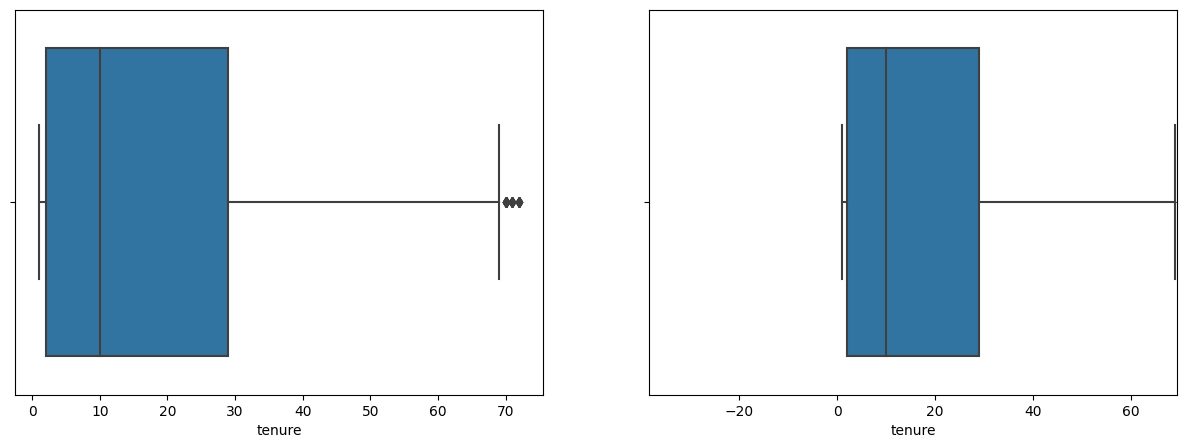

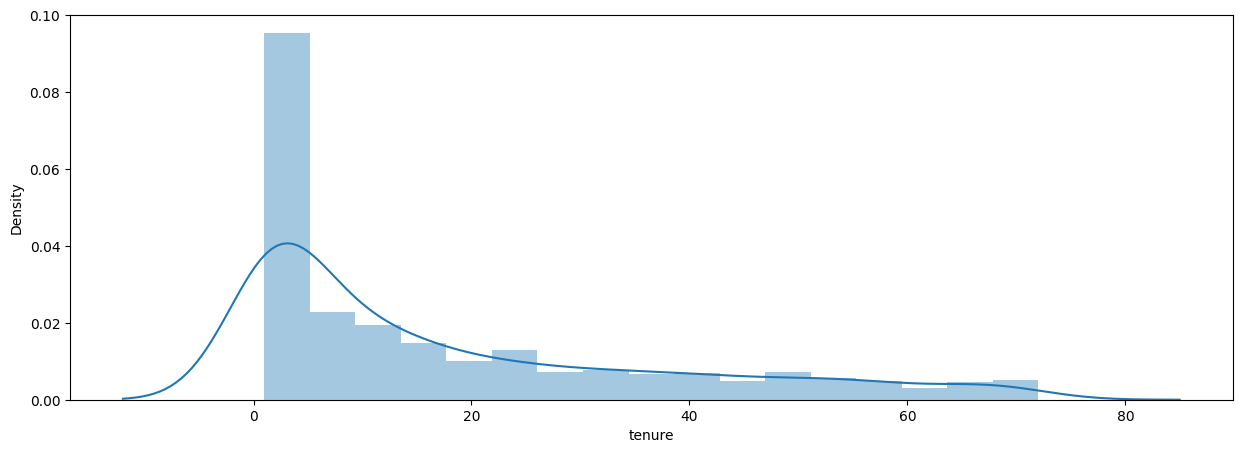

In [ ]:
diagrama_caixa(churns['tenure'])
histograma(churns['tenure'])

O gráfico nos mostra que a maior parte dos churns ocorre com menos de 30 meses de permanência

>> ### 4.1.2. Valor Mensal Cobrado

<ipython-input-89-367f47a73ee6>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


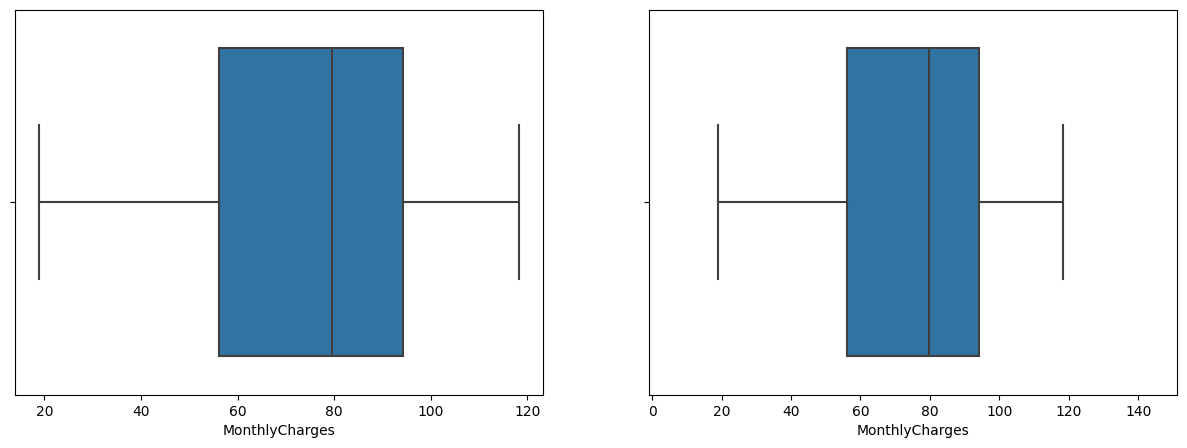

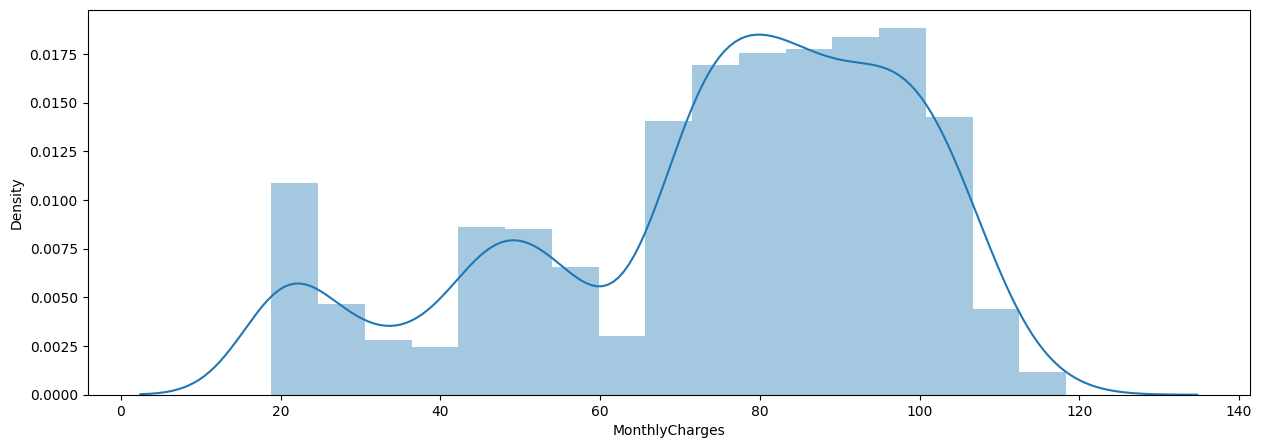

In [ ]:
diagrama_caixa(churns['MonthlyCharges'])
histograma(churns['MonthlyCharges'])

O gráfico aponta que cerca de 75% dos clientes que deram churn pagavam menos do que R$100,00 mensais. Este conjunto de dados não possui informação sobre a renda mensal dos clientes mas dá um indicativo de que o preço do serviço não é um fator tão forte no cancelamento do contrato


<Axes: >

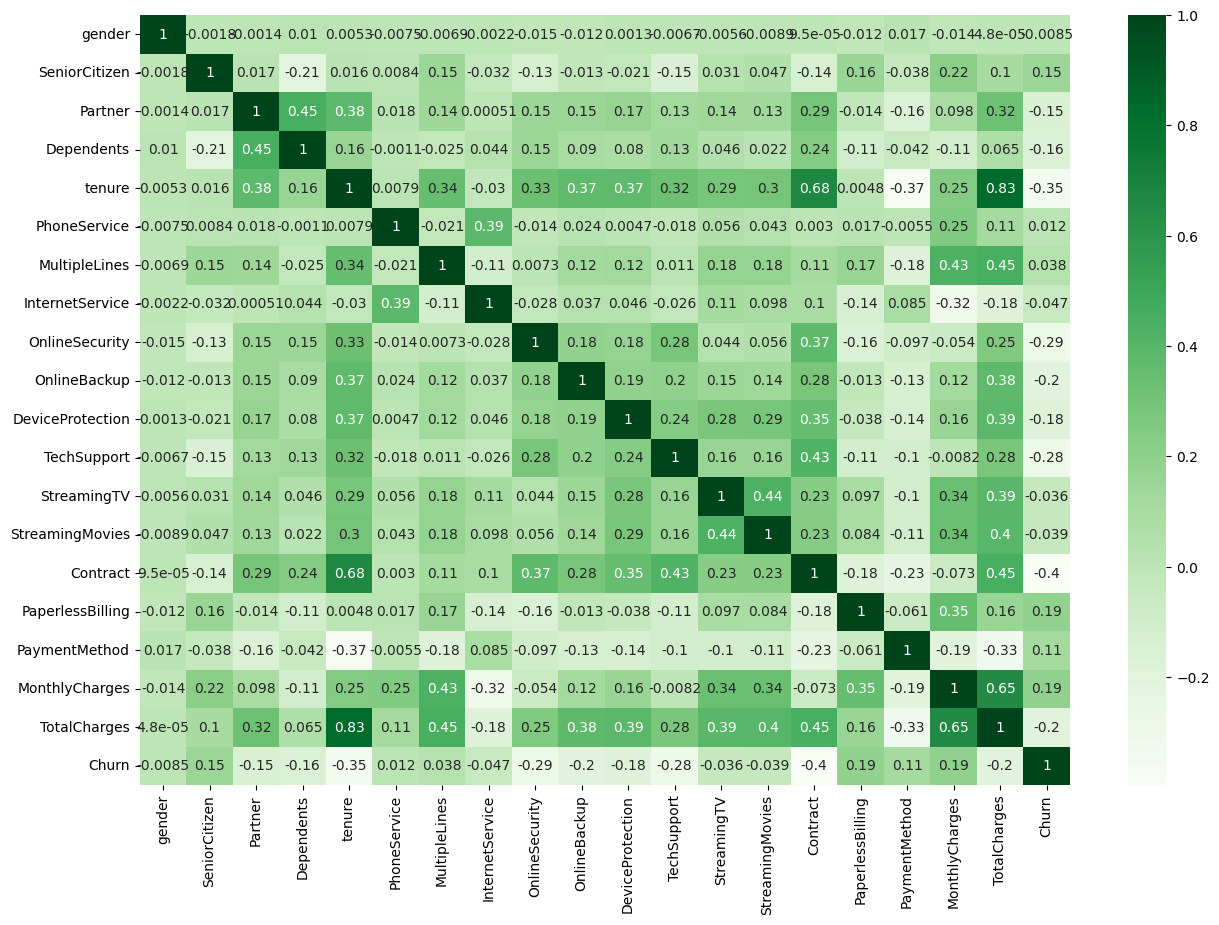

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='Greens')


> ## 4.2. Variáveis Categóricas ou Booleanas

In [ ]:
# criando uma lista com as colunas true or false
colunas_tf=['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
            'PaperlessBilling']
df_cod = df.copy()
for coluna in colunas_tf:
  df_cod.loc[df[coluna]=='Yes', coluna]=1
  df_cod.loc[df[coluna]=='No', coluna]=0
  churns.loc[df[coluna]=='Yes', coluna]=1
  churns.loc[df[coluna]=='No', coluna]=0


>> ### 4.2.1. Idade (Idoso ou não)





In [ ]:
idoso = churns['SeniorCitizen'].value_counts()
perc_idoso = idoso[1] / (idoso[0]+idoso[1])
print('{:.2f}%'.format(perc_idoso*100))

25.47%


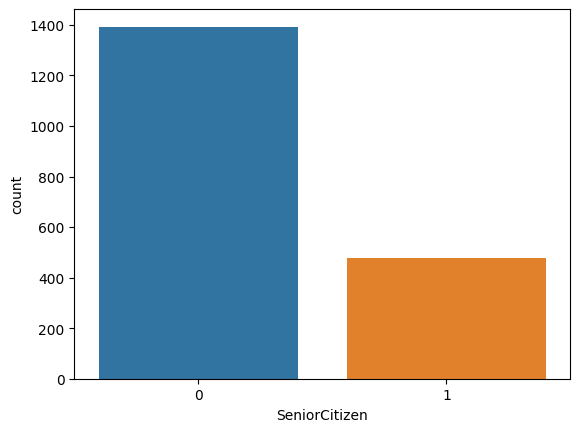

In [ ]:
grafico=sns.countplot(x='SeniorCitizen', data=churns)
grafico.tick_params(axis= 'x')

Os dados indicam que apenas 25% dos churns são de idosos. Ou seja, estes são menos exigentes e tem menor disposição ao cancelamento

>> ### 4.2.2. Sociedade

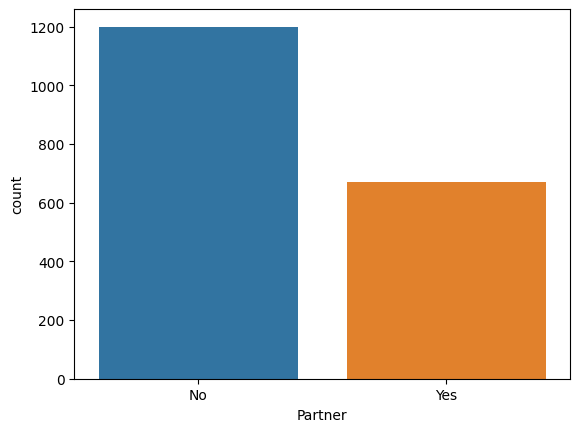

In [ ]:
grafico=sns.countplot(x='Partner', data=churns)
grafico.tick_params(axis= 'x')

Os dados mostram que clientes que não possuem sócios cancelam os serviços com maior frequência do que os que possuem algum tipo de sociedade. Isto pode ser explicado pelo fato de que, no caso de empresas, a não sociedade permite maior flexibilidade e liberdade para tomar decisões

>> ### 4.2.3. Dependentes

In [ ]:
dependentes = churns['Dependents'].value_counts()
perc_depend = dependentes[1] / (dependentes[0]+dependentes[1])
print('{:.2f}%'.format(perc_depend*100))

17.44%


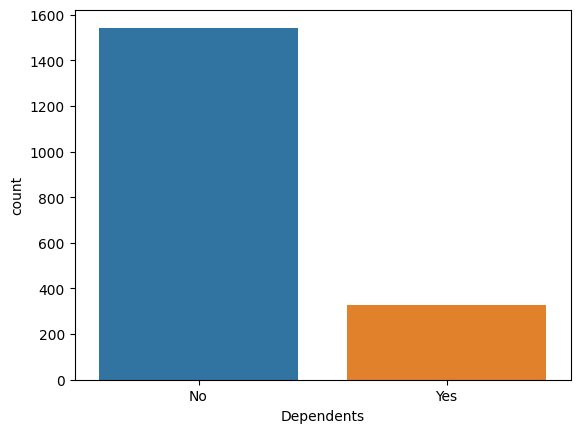

In [ ]:
grafico=sns.countplot(x='Dependents', data=churns)
grafico.tick_params(axis= 'x')

Os dados nos mostram que menos de 20% dos churns vem de clientes que possuem dependentes. A grande maioria são de clientes solteiros e/ou sem filhos. Uma hipótese para isto é de que para clientes sem dependentes, quando o serviço para de lhes atender não há nenhum tipo de restrição que os impeçam de cancelar. Para os outros clientes, mesmo que o serviço não seja útil para ele, seus dependentes provavelmente desfrutam deste serviço e por isso, tendem a não cancelar

>> ### 4.2.4. Serviço Telefônico

In [ ]:
telef = churns['PhoneService'].value_counts()
perc_telef = telef[0] / (telef[0]+telef[1])
print('Possuiam Telefone: {:.2f}%'.format(perc_telef*100))


Possuiam Telefone: 90.90%


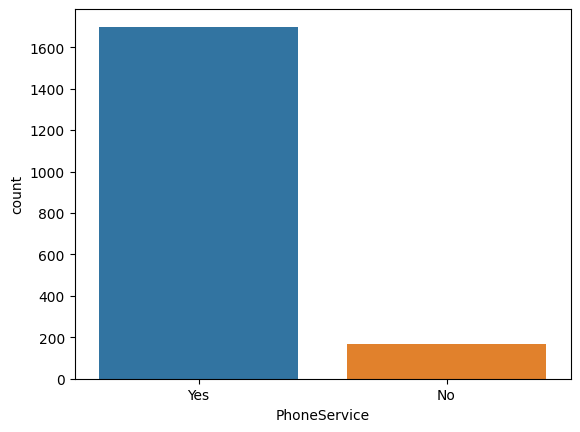

In [ ]:
grafico=sns.countplot(x='PhoneService', data=churns)
grafico.tick_params(axis= 'x')

Os dados nos mostram que 90% dos clientes que deram churn possuiam o serviço telefônico. Uma hipótese para este evento é que este serviço está ficando, ano após ano, mais obsoleto a medida que novas tecnologias de comunicação vêm surgindo e não necessariamente que o serviço oferecido pela empresa seja de má qualidade

>> ### 4.2.5. Múltiplas Linhas

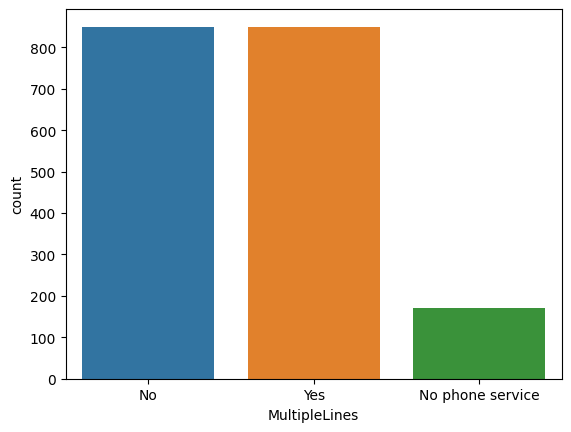

In [ ]:
grafico=sns.countplot(x='MultipleLines', data=churns)
grafico.tick_params(axis= 'x')

O gráfico sugere que o número de linhas telefônicas não é uma variável determinante para o encerramento do vínculo com o cliente visto que a frequência de churns com uma única linha ou mais é semelhante. Outro insight interessante é a confirmação da análise anterior que aponta que poucos clientes sem telefone deram churn

>> ### 4.2.6. Tipo de Internet

In [ ]:
net = churns['InternetService'].value_counts()
soma=net[0]+net[1]
perc_net = soma / (net[0]+net[1]+net[2])
print('Possuiam Internet: {:.2f}%'.format(perc_net*100))

Possuiam Internet: 93.95%


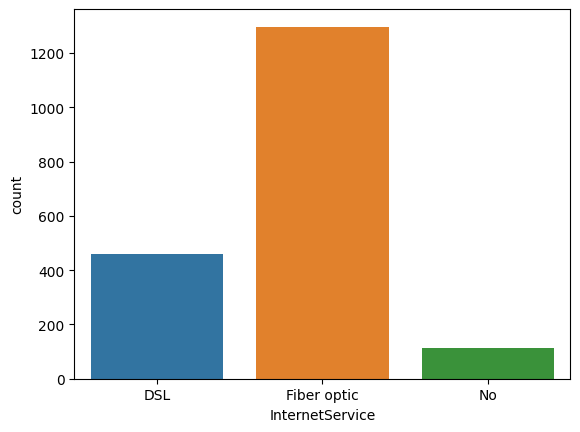

In [ ]:
grafico=sns.countplot(x='InternetService', data=churns)
grafico.tick_params(axis= 'x')

Os dados nos mostram que cerca de 94% dos churns vieram de clientes que possuem serviço de internet e que destes, a maioria possuia fibra ótica

>> ### 4.2.7. Serviço de Streaming

In [ ]:
streaming = churns['StreamingTV'].value_counts()
soma=streaming.sum()
perc_streaming = streaming[0] / soma
print('Não Possuiam Streaming: {:.2f}%'.format(perc_streaming*100))


Não Possuiam Streaming: 50.40%


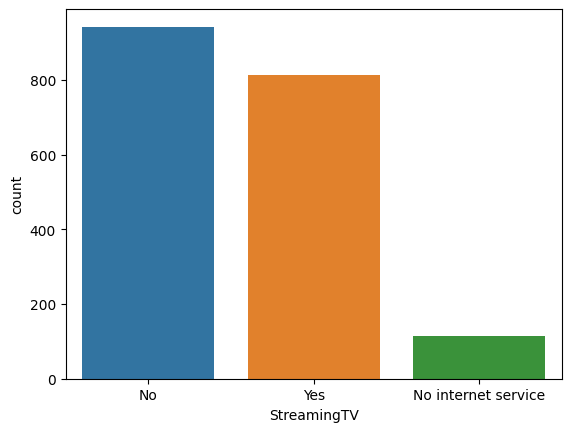

In [ ]:
grafico=sns.countplot(x='StreamingTV', data=churns)
grafico.tick_params(axis= 'x')


In [ ]:
clientes_streaming = df_cod[df_cod['StreamingTV']==1]['StreamingTV'].count()
churns_streaming = churns[churns['StreamingTV']==1]['StreamingTV'].count()
perc_churns_streaming = churns_streaming/clientes_streaming

clientes_semstreaming = df_cod[df_cod['StreamingTV']==0]['StreamingTV'].count()
churns_semstreaming = churns[churns['StreamingTV']==0]['StreamingTV'].count()
perc_churns_semstreaming = churns_semstreaming/clientes_semstreaming

print('Taxa de churn de clientes com StreamingTV: {:.2f}%'.format(perc_churns_streaming*100))
print('Taxa de churn de clientes sem StreamingTV: {:.2f}%'.format(perc_churns_semstreaming*100))

Taxa de churn de clientes com StreamingTV: 0.00%
Taxa de churn de clientes sem StreamingTV: 0.00%


In [ ]:
clientes_streaming

1520

As análises sugerem que mais da metade dos churns ocorreram por clientes que não possuiam o serviço StreamingTV. Essa informação pode nos mostrar que este serviço pode melhorar o cenário de churns dentro da empresa

>> ### 4.2.8. Serviço de StreamingMovies

In [ ]:
clientes_streaming = df[df['StreamingMovies']==2]['StreamingMovies'].count()
churns_streaming = churns[churns['StreamingMovies']=='Yes']['StreamingMovies'].count()
perc_churns_streaming = churns_streaming/clientes_streaming

clientes_semstreaming = df[df['StreamingMovies']==0]['StreamingMovies'].count()
churns_semstreaming = churns[churns['StreamingMovies']=='No']['StreamingMovies'].count()
perc_churns_semstreaming = churns_semstreaming/clientes_semstreaming

print('Taxa de churn de clientes com StreamingMovies: {:.2f}%'.format(perc_churns_streaming*100))
print('Taxa de churn de clientes sem StreamingMovies: {:.2f}%'.format(perc_churns_semstreaming*100))

Taxa de churn de clientes com StreamingMovies: 29.95%
Taxa de churn de clientes sem StreamingMovies: 33.73%


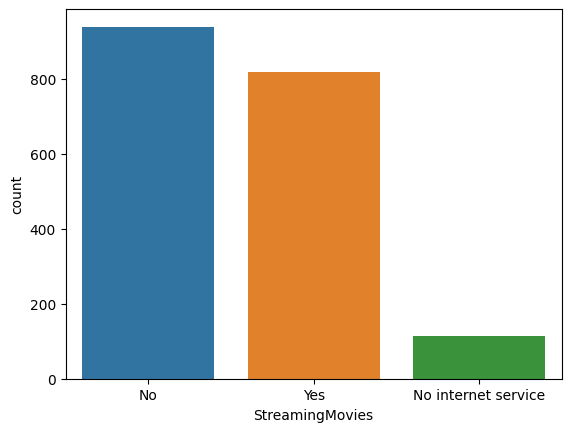

In [ ]:
grafico=sns.countplot(x='StreamingMovies', data=churns)
grafico.tick_params(axis= 'x')

Este serviço tem aspectos muitos semelhantes ao StreamingTV, inclusive no número de clientes adeptos.
Cabe verificar se é possível eliminar uma destas features sem que haja perda de desempenho do modelo de predição

>> ### 4.2.9 Serviços adicionais

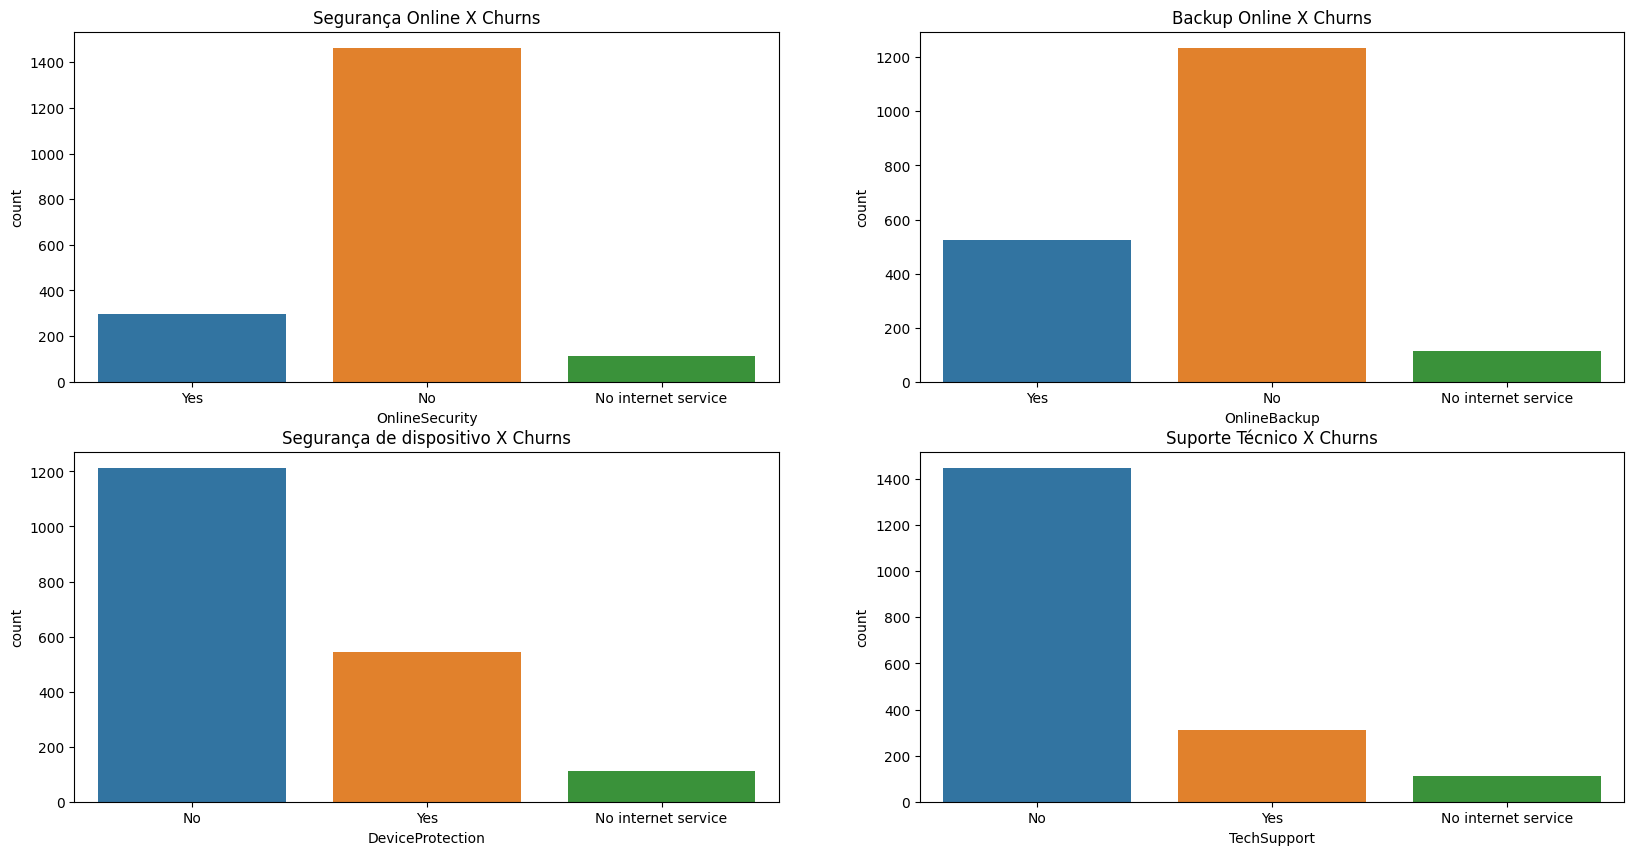

In [ ]:
# Configurando a figura e os eixos
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))

# Plotando os gráficos de colunas
sns.countplot(x='OnlineSecurity', data=churns, ax=axs[0,0])
sns.countplot(x='OnlineBackup', data=churns, ax=axs[0,1])
sns.countplot(x='DeviceProtection', data=churns, ax=axs[1,0])
sns.countplot(x='TechSupport', data=churns, ax=axs[1,1])


# Configurando os títulos dos subplots
axs[0, 0].set_title("Segurança Online X Churns")
axs[0, 1].set_title("Backup Online X Churns")
axs[1, 0].set_title("Segurança de dispositivo X Churns")
axs[1, 1].set_title("Suporte Técnico X Churns")

# Exibindo a figura
plt.show()


In [ ]:
alvos = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

for feature in alvos:
  churns_com = churns[churns[feature]=='Yes'][feature].count()
  total_churn = churns[churns[feature]=='No'][feature].count() + churns_com
  perc_churn_sem = 1-(churns_com/total_churn)

  print('Percentual de churns que não possuiam {}: {:.2f}%'.format(feature, perc_churn_sem*100))

Percentual de churns que não possuiam OnlineSecurity: 83.20%
Percentual de churns que não possuiam OnlineBackup: 70.22%
Percentual de churns que não possuiam DeviceProtection: 68.96%
Percentual de churns que não possuiam TechSupport: 82.35%


Neste conjunto de gráficos é possível perceber a importância dos serviços adicionais na retenção dos clientes. É possível identificar um enorme índice de clientes que deixaram a empresa não possuindo os serviços analisados. Muito provavelmente eles tiveram algum tipo de problema nestes sentidos

>> ### 4.2.10. Tipo de Contrato

In [ ]:
mensal_churn = churns[churns['Contract']=='Month-to-month']['Contract'].count()
mensal_clientes = df[df['Contract']==0]['Contract'].count()
porc_mensal = mensal_churn / mensal_clientes

anual_churn = churns[churns['Contract']=='One year']['Contract'].count()
anual_clientes = df[df['Contract']==1]['Contract'].count()
porc_anual = anual_churn / anual_clientes

doisanos_churn = churns[churns['Contract']=='Two year']['Contract'].count()
doisanos_clientes = df[df['Contract']==2]['Contract'].count()
porc_doisanos = doisanos_churn / doisanos_clientes

print('Percentual de churn por contrato mensal: {:.2f}%'.format(porc_mensal*100))
print('Percentual de churn por contrato anual: {:.2f}%'.format(porc_anual*100))
print('Percentual de churn por contrato de dois anos: {:.2f}%'.format(porc_doisanos*100))



Percentual de churn por contrato mensal: 42.71%
Percentual de churn por contrato anual: 11.28%
Percentual de churn por contrato de dois anos: 2.85%


Text(0.5, 1.0, 'Tipo de Contrato X Qtde Churn')

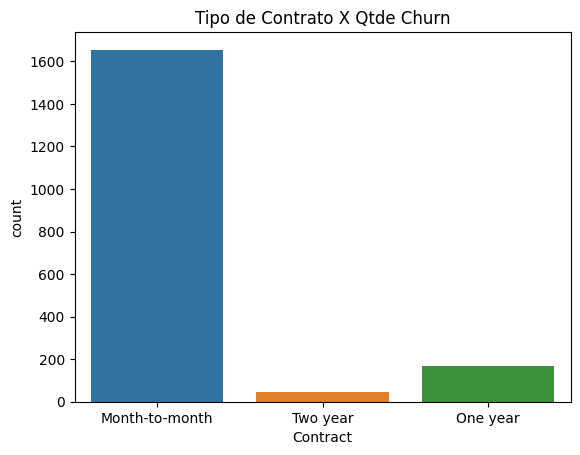

In [ ]:
grafico=sns.countplot(x='Contract', data=churns)
grafico.tick_params(axis= 'x')
grafico.set_title("Tipo de Contrato X Qtde Churn")



Text(0.5, 1.0, 'Tipo de Contrato X Qtde Clientes na Base')

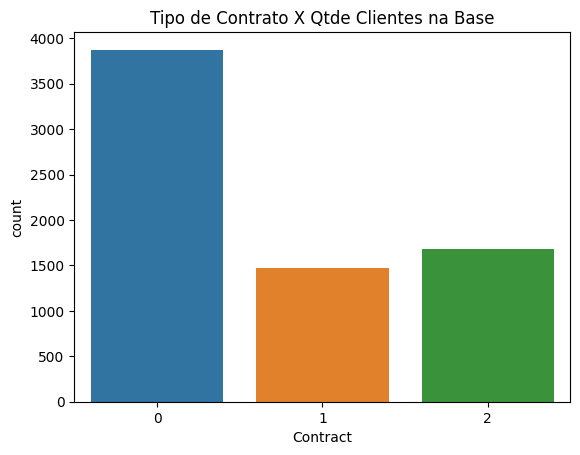

In [ ]:
grafico2=sns.countplot(x='Contract', data=df_cod)
grafico2.tick_params(axis= 'x')
grafico2.set_title("Tipo de Contrato X Qtde Clientes na Base")

  A partir da análise feita é possível visualizar que o número de churns por tipo de contrato acompanha o seu volume na base de clientes: em outras palavras, o contrato mensal é o tipo mais comum dentro da base e, por sua vez, também é o que mais tem churn.




  Proporcionalmente, o contrato mensal também é o que mais carrega churns, com aproximadamente 43% da base de clientes.

  Um fato curioso é que a taxa de churns no contrato de dois anos é baixíssima se comparada as demais sendo que seu volume de ocorrência dentro da base é próximo ao anual.

  Isto quer dizer que pode ser interessante alocar esforços na venda deste tipo de contrato visto que, com ele, a retenção é amior





>> ### 4.2.11. Método de pagamento

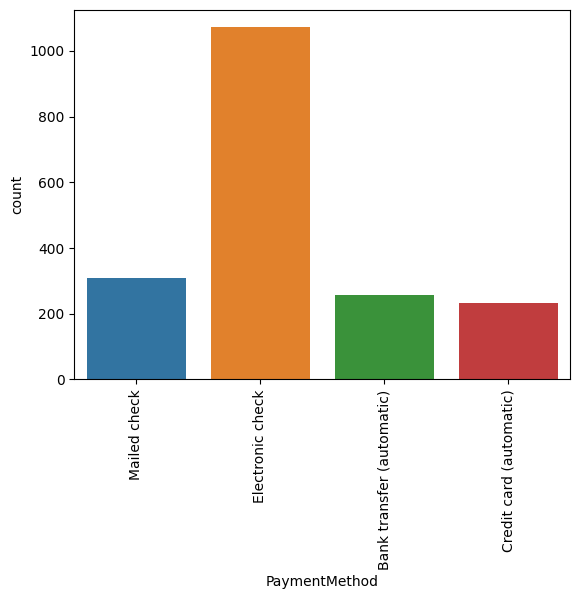

In [ ]:
grafico=sns.countplot(x='PaymentMethod', data=churns)
grafico.tick_params(axis= 'x', labelrotation=90)

Pode-se observar que clientes que tem Cheque Eletrônico como método de pagamento, tendem mais a dar churn

>> ### 4.2.12. Pagamento sem papel

In [ ]:
churn_papel = churns[churns['PaperlessBilling']=='Yes']['PaperlessBilling'].count()
total_churns = churns[churns['PaperlessBilling']=='No']['PaperlessBilling'].count() + churn_papel

perc_churn_papel = churn_papel/total_churns
print('Percentual de churns utilizando faturamento sem papel: {:.2f}%'.format(perc_churn_papel*100))

Percentual de churns utilizando faturamento sem papel: 74.91%


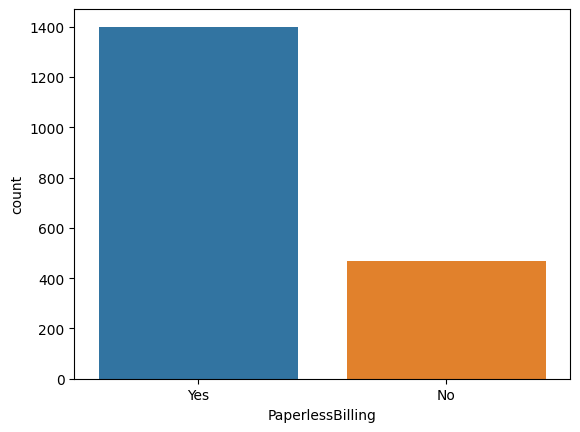

In [ ]:
grafico=sns.countplot(x='PaperlessBilling', data=churns)
grafico.tick_params(axis= 'x')

A análise nos mostra que o número de churns é muito maior em clientes que recebem a fatura sem papel. Uma possível hipótese para isto é que pessoas que preferem receber a fatura de forma online (seja email, app, site, etc) tendem a ter maior facilidade em encontrar meios de cancelamento online. Já quem recebe faturas com papel, tendem a ter menor familiaridade online e consequentemente, menor acesso aos vários modos de cancelamento, se limitando a métodos de ligação por exemplo

> ## 4.3. Insights e Sugestões

Com base nos dados fornecidos, podemos fazer algumas análises para traçar o perfil de clientes que cancelaram. Alguns insights que podemos obter são:

- O churn é maior entre clientes que têm contrato de mês a mês, enquanto que clientes com contrato de dois anos têm a menor taxa de churn.
Os clientes que têm faturamento sem papel têm uma taxa de churn maior do que os que recebem contas impressas.
- A taxa de churn é maior entre os clientes que usam serviços de internet de fibra ótica do que os que usam DSL.
- A taxa de churn é maior entre clientes que não possuem serviços adicionais, como segurança online, backup online, proteção de dispositivo, suporte técnico, streaming de TV e streaming de filmes.
- Clientes que pagam mais pela assinatura mensal e que pagaram mais em cobranças totais têm uma taxa de churn mais baixa do que clientes que pagam menos.
- A taxa de churn é maior entre os clientes que usam cartão de crédito automático como forma de pagamento, enquanto que a taxa de churn é menor para clientes que usam transferência bancária automática.

Com base nessas informações, podemos dizer que os clientes que cancelam com mais frequência são aqueles que têm menos compromisso com a empresa, ou seja, aqueles que têm contratos de curto prazo e que não utilizam muitos serviços adicionais. Além disso, clientes que utilizam serviços de fibra ótica e que pagam por cartão de crédito automático são mais propensos a cancelar. Por outro lado, clientes que têm contratos mais longos e que pagam mais são mais propensos a permanecer na empresa.

Com base no perfil traçado dos clientes que têm maior probabilidade de cancelar, existem algumas estratégias que podem ser implementadas para diminuir a taxa de churn:

- Oferecer promoções e descontos para clientes com contratos de curto prazo que renovarem por períodos mais longos, incentivando-os a permanecer por mais tempo na empresa.
- Melhorar a qualidade dos serviços de internet de fibra ótica e investir em melhorias para reduzir a insatisfação dos clientes que utilizam esse tipo de serviço.
- Oferecer pacotes de serviços adicionais para clientes que não os possuem, tornando a oferta mais atraente e aumentando a percepção de valor do cliente.
- Melhorar a qualidade do atendimento ao cliente, com treinamento para equipe de suporte técnico, oferecendo soluções mais eficazes e demonstrando maior empatia e disponibilidade para ajudar.
- Oferecer mais opções de formas de pagamento além do cartão de crédito automático, como boleto bancário e pix, para aumentar a conveniência do cliente e reduzir a probabilidade de falhas no pagamento.

# 5. Modelo

> ## 5.1. Dividindo os dados de treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balanc, y_balanc, test_size=0.3, random_state=42)

> ## 5.2 Criando o modelo

Usarei, inicialmente, um modelo de LogisticRegression

In [ ]:
# criação do modelo LogisticRegression e treinamento com os dados de treino
lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression()

> ## 5.3. Testando do modelo

Irei fazer o teste e avaliar a performance do modelo, usarei algumas métricas de avaliação:
- Acurácia
- Recall
- Precisão
- Matriz de confusão

In [ ]:
y_pred = lr.predict(X_test)
print('Acurácia: ', accuracy_score(y_test, y_pred))
print('Matriz de confusão: ', confusion_matrix(y_test, y_pred))
print('Recall: ', classification_report(y_test, y_pred))



Acurácia:  0.7856681730148483
Matriz de confusão:  [[1141  422]
 [ 242 1293]]
Recall:                precision    recall  f1-score   support

           0       0.83      0.73      0.77      1563
           1       0.75      0.84      0.80      1535

    accuracy                           0.79      3098
   macro avg       0.79      0.79      0.79      3098
weighted avg       0.79      0.79      0.79      3098



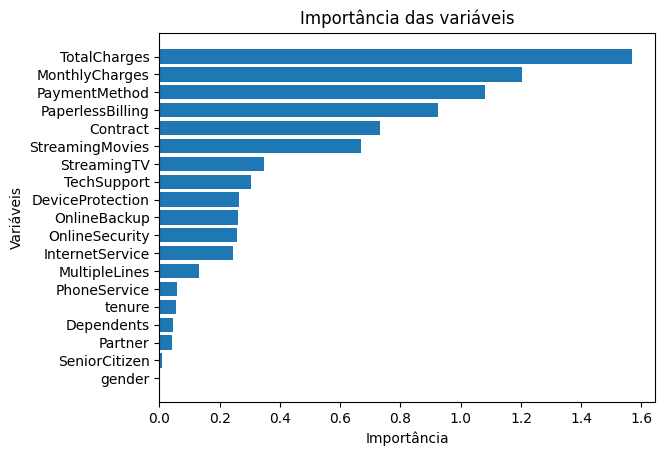

In [ ]:
feature_importances = list(abs(lr.coef_)[0])
feature_importances.sort()
feature_names = list(X.columns)
plt.barh(feature_names, feature_importances)
plt.title("Importância das variáveis")
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.show()

Como podemos ver, as features 'gender' e 'SeniorCitizen' são pouco relevantes ao modelo. Por isso, cabe um teste sem estas para verificar a performance

## 5.4. Ajustando o modelo

Como há relativamente poucos dados de amostra, aplicaremos uma técnica de geração de dados (dados sintéticos) e faremos o processo de treinamento e teste em loop para que possamos pegar uma média do desempenho visto que os dados estão sendo gerados de forma aleatória e que, a cada requisição, o desempenho seria diferente

In [ ]:
acc = 0
avg_recall1 = 0
avg_recall0 = 0
# Gerar dados sintéticos
for i in range(0,500):
  n=50
  gender = np.random.choice(["Male", "Female"], size=n)
  senior_citizen = np.random.choice([0, 1], size=n)
  partner = np.random.choice(['Yes', 'No'], size=n)
  dependents = np.random.choice(['Yes', 'No'], size=n)
  tenure = (np.random.randint(0, 30, size=n))
  phone_service = np.random.choice(['Yes', 'No'], size=n)
  multiple_lines = np.random.choice(["Yes", "No", "No phone service"], size=n)
  internet_service = np.random.choice(["DSL", "Fiber optic", "No"], size=n)
  online_security = np.random.choice(["Yes", "No", "No internet service"], size=n)
  online_backup = np.random.choice(["Yes", "No", "No internet service"], size=n)
  device_protection = np.random.choice(["Yes", "No", "No internet service"], size=n)
  tech_support = np.random.choice(["Yes", "No", "No internet service"], size=n)
  streaming_tv = np.random.choice(["Yes", "No", "No internet service"], size=n)
  streaming_movies = np.random.choice(["Yes", "No", "No internet service"], size=n)
  contract = np.random.choice(["Month-to-month", "One year", "Two year"], size=n)
  paperless_billing = np.random.choice(["Yes", "No"], size=n)
  payment_method = np.random.choice(["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"], size=n)
  monthly_charges = np.round(np.random.normal(70, 15, size=n), 2)
  total_charges = monthly_charges * tenure
  churn = np.random.choice(['Yes', 'No'], size=n)

  # criando DataFrame sintetico
  df_sint = pd.DataFrame({
      'gender': gender,
      'SeniorCitizen': senior_citizen,
      'Partner': partner,
      'Dependents': dependents,
      'tenure': tenure,
      'PhoneService': phone_service,
      'MultipleLines': multiple_lines,
      'InternetService': internet_service,
      'OnlineSecurity': online_security,
      'OnlineBackup': online_backup,
      'DeviceProtection': device_protection,
      'TechSupport': tech_support,
      'StreamingTV': streaming_tv,
      'StreamingMovies': streaming_movies,
      'Contract': contract,
      'PaperlessBilling': paperless_billing,
      'PaymentMethod': payment_method,
      'MonthlyCharges': monthly_charges,
      'TotalCharges': total_charges,
      'Churn': churn
  })

  df_ajust = pd.concat([df, df_sint], ignore_index=True)

  # converter dados categóricos em numéricos
  encoder = LabelEncoder()
  for col in df_ajust.columns:
      if df_ajust[col].dtype == 'object':
          df_ajust[col] = encoder.fit_transform(df_ajust[col])

  # normalizar os dados numéricos
  scaler = StandardScaler()
  numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
  df_ajust[numeric_cols] = scaler.fit_transform(df_ajust[numeric_cols])

  X_ajust = df_ajust.drop(['Churn'], axis=1)
  y_ajust= df_ajust['Churn']
  # aplicando o SMOTE para gerar novas amostras da classe minoritária
  smote = SMOTE(random_state=42)
  X_balanc2, y_balanc2 = smote.fit_resample(X_ajust, y_ajust)

  # verificando a quantidade de amostras em cada classe
  count_churn_0, count_churn_1 = y_balanc2.value_counts()
  # print("Não houve churn: ", count_churn_0)
  # print("Houve churn: ", count_churn_1)

  X_train, X_test, y_train, y_test = train_test_split(X_balanc2, y_balanc2, test_size=0.4, random_state=42)
  lr2 = LogisticRegression()
  lr2.fit(X_train, y_train)
  y_pred = lr2.predict(X_test)
  acc = acc + accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, output_dict=True)
  avg_recall1 += report['1']['recall']
  avg_recall0 += report['0']['recall']

avg_recall1 /= 500
avg_recall0 /= 500

acc_med = acc/(i+1)
print('Acurácia: ', acc_med)
print('Recall churn: ', avg_recall1)
print('Recall não churn: ', avg_recall0)

Acurácia:  0.7823101901112087
Recall churn:  0.8291519712487292
Recall não churn:  0.7365491360168094


Com a técnica empregada acima, não foi possível obter uma melhora significativa no desempenho do modelo

# 6. Deploy

In [ ]:
import joblib
joblib.dump(lr, 'modelo_lr.joblib')

['modelo_lr.joblib']